# Test Overlap between sources in a blend

In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
from lsst.utils import getPackageDir
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)
plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)

In [2]:
# Load the data
dataPath = os.path.abspath(os.path.join(lsst.utils.getPackageDir("testdata_deblender"), 'sim_data'))
filters = ["u", "g", "r", "i", "z", 'y']
imgFilename = os.path.join(dataPath, "test1/{0}_{1}.fits")
catFilename = os.path.join(dataPath, "test1/det_merge.fits")
simFilename = os.path.join(dataPath, "test1/catalog_true.fits")

expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename, useExactPeaks=True)
#pidx = 3
#condition = (expDb.mergedTable["peaks"]<=10) & (expDb.mergedTable["peaks"]>1)
pidx = 0
condition = (expDb.mergedTable["peaks"]<=5) & (expDb.mergedTable["peaks"]>1)
footprint, peaks = expDb.getParentFootprint(parentIdx=pidx, condition=condition, display=False)
deblend = proximal.DeblendedParent(expDb, footprint, peaks)

INFO:lsst.meas.deblender.proximal:Total parents: 9
INFO:lsst.meas.deblender.proximal:Unblended sources: 4
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 5


INFO:lsst.meas.deblender:Sources not detected: 0



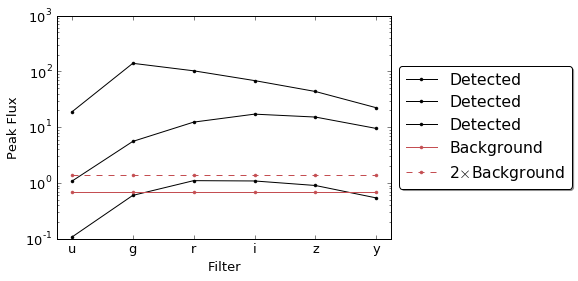

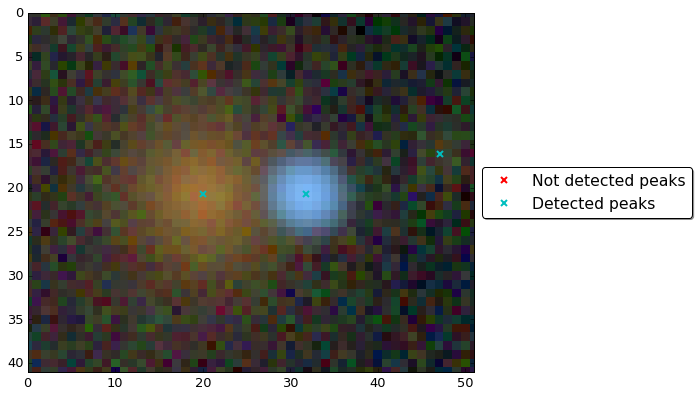

In [3]:
# Build a table of peaks detected by the pipeline
peakTable = sim.buildFootprintPeakTable(footprint, filters, peaks=peaks)
# Estimate the noise in the image
avgNoise = sim.getNoise(expDb.calexps)
simTable,idx, unmatchedTable = sim.matchFootprintToRef(footprint, peakTable, expDb.simTable,
                                                        filters,avgNoise=avgNoise, expDb=expDb,)
# Calculate the flux for isolated (non-blended) sources
sim.calculateIsolatedFlux(filters, expDb, peakTable, simTable, avgNoise)

In [4]:
%time dbr = sim.deblendFootprintOld(filters, expDb, footprint, peakTable)

CPU times: user 46.2 ms, sys: 2.26 ms, total: 48.5 ms
Wall time: 47.2 ms


In [5]:
peakCoords = np.array([simTable["x"]+.5,simTable["y"]+.5]).T
%time glmm = expDb.deblendParent(condition=condition, parentIdx=pidx, display=False, maxiter=200, constraints='MS', usePsf=False, psfThresh=3e-3, e_rel=1e-2, monotonicUseNearest=True, peaks=peakCoords, l0_thresh=.1)

INFO:lsst.meas.deblender.proximal:constraints: MS
INFO:proxmin.algorithms:Completed 200 iterations


CPU times: user 956 ms, sys: 10.9 ms, total: 967 ms
Wall time: 966 ms


In [6]:
def getGlmm2():
    peakCoords = np.array([simTable["x"]+.5,simTable["y"]+.5]).T
    glmm2 = expDb.deblendParent(
        condition=condition,
        parentIdx=pidx,
        display=False,
        maxiter=1000,
        #min_iter=20,
        strict_constraints="M",
        constraints="S",
        usePsf=False,
        psfThresh=3e-3,
        e_rel=1e-2,
        monotonicUseNearest=True,
        #, l0_thresh=.1
        peaks=peakCoords,
        algorithm="GLMM",
        #monotonic_thresh=1e-3
    )
    return glmm2

%time glmm2 = getGlmm2()


INFO:lsst.meas.deblender.proximal:constraints: S
INFO:proxmin.algorithms:Completed 649 iterations


CPU times: user 2.51 s, sys: 24.2 ms, total: 2.54 s
Wall time: 2.54 s


In [7]:
oldTemplates = sim.getODBTemplates(footprint, dbr, display=False)
simTemplates = sim.getSimTemplates(simTable, filters, footprint=footprint, display=False)
debTemplates = glmm.getAllTemplates()
debApportioned = glmm.getFluxPortionTemplates()
monoTemplates = glmm2.getAllTemplates()
monoApportioned = glmm2.getFluxPortionTemplates()

INFO:lsst.meas.deblender.display:Peak 0


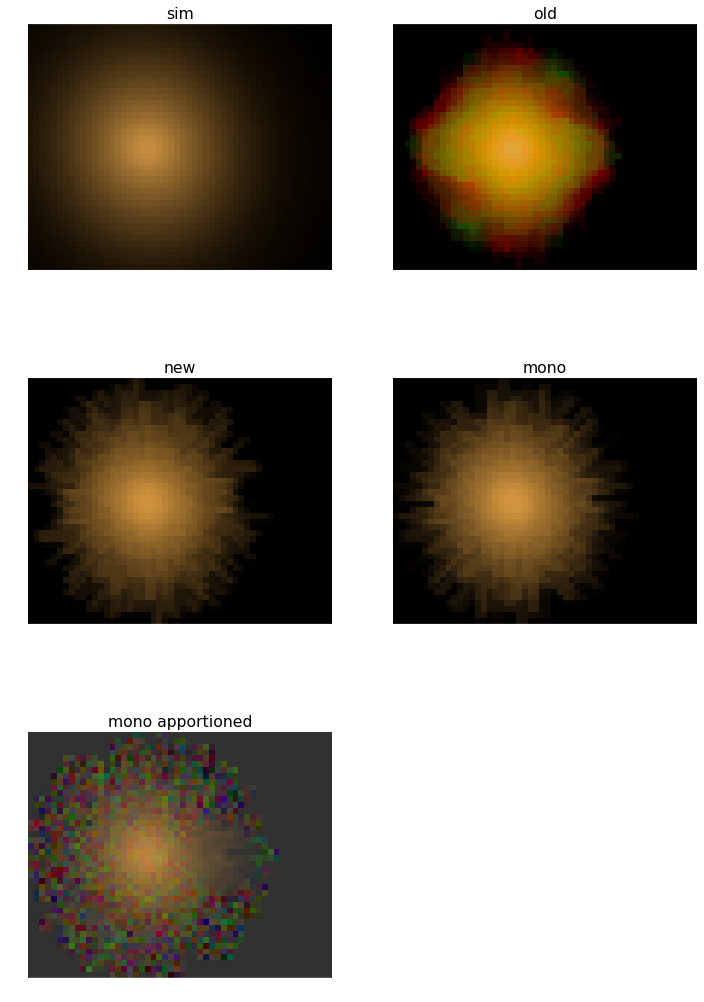

INFO:lsst.meas.deblender.display:Peak 1


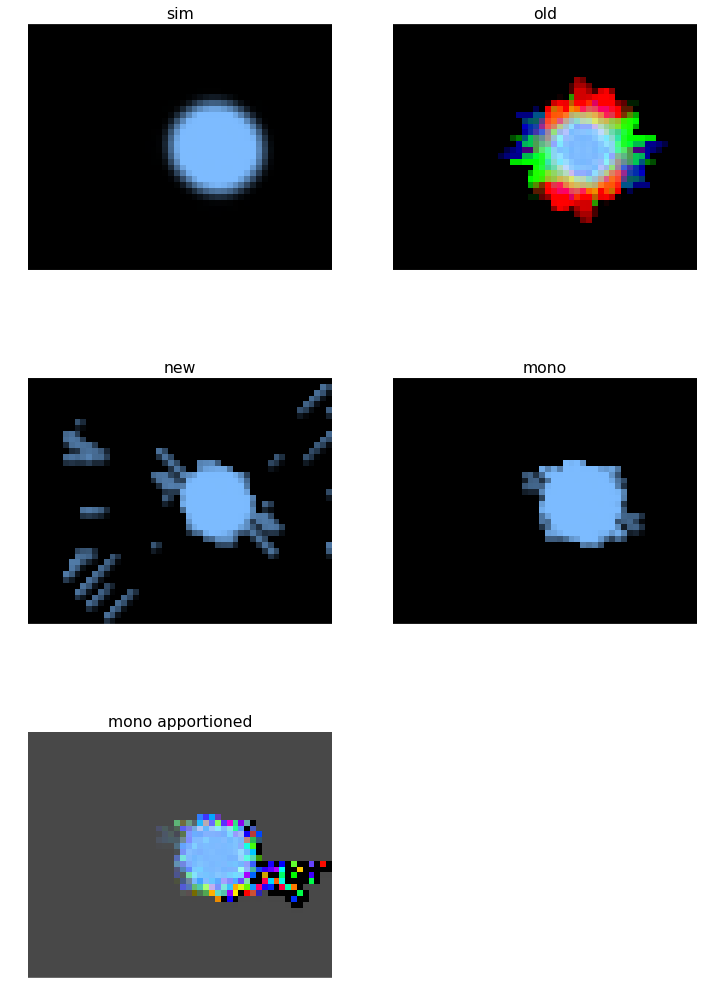

INFO:lsst.meas.deblender.display:Peak 2


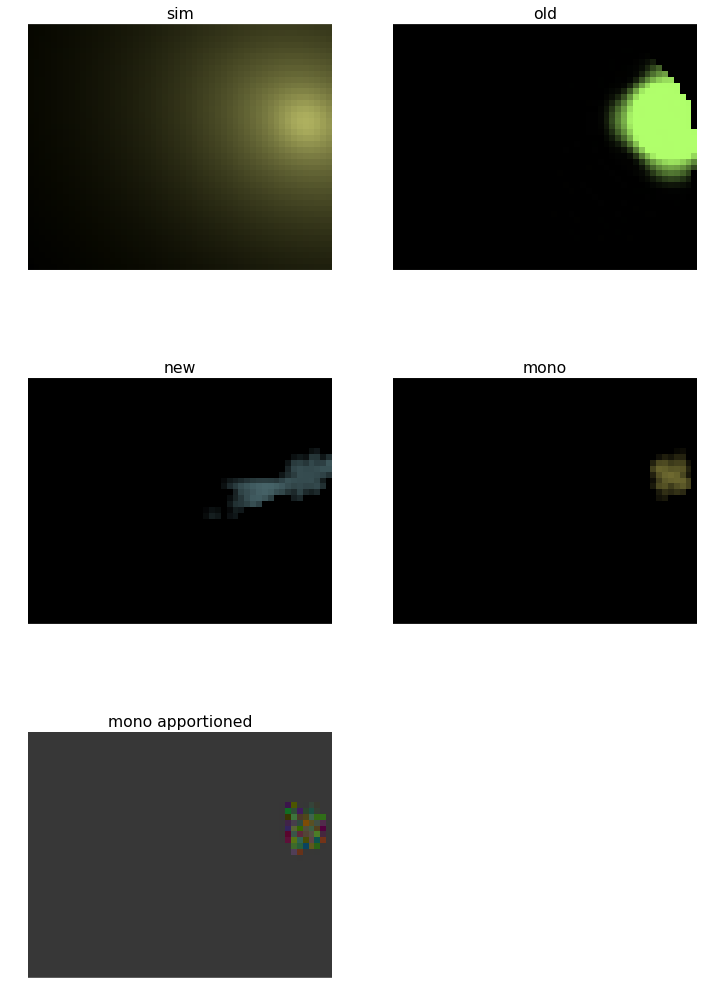

In [8]:
display.plotAllTemplates(OrderedDict([
    ("sim", simTemplates),
    ("old", oldTemplates),
    ("new", debTemplates),
    #("new apportioned", debApportioned),
    ("mono", monoTemplates),
    ("mono apportioned", monoApportioned),
]), columns=2)

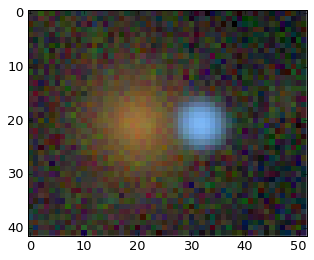

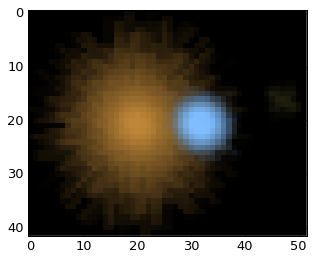

In [9]:
calImg = np.array([calexp[footprint.getBBox()].getMaskedImage().getImage().getArray()
                                 for calexp in expDb.calexps])
display.plotColorImage(calImg);
display.plotColorImage(glmm2.model);

INFO:lsst.meas.deblender:Old Deblender Comparison


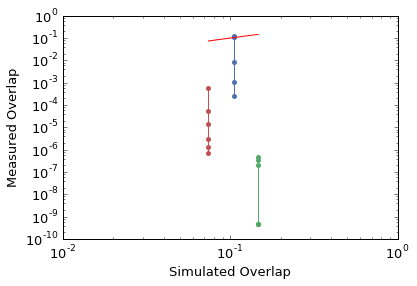

INFO:lsst.meas.deblender:NMF Deblender Comparison


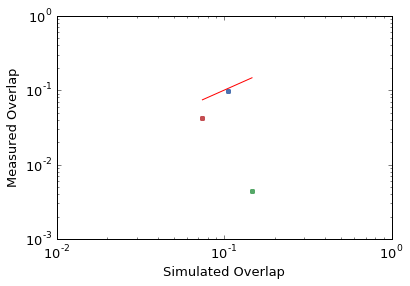

INFO:lsst.meas.deblender:monotonic NMF Deblender


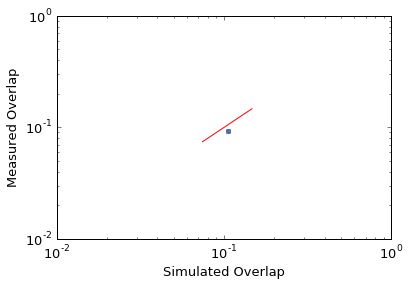

In [10]:
logger.info("Old Deblender Comparison")
ss, ds = sim.compareOverlap(simTemplates, oldTemplates, show=False)
logger.info("NMF Deblender Comparison")
ss, ds = sim.compareOverlap(simTemplates, debTemplates, show=False)
logger.info("monotonic NMF Deblender")
ss, ds = sim.compareOverlap(simTemplates, monoTemplates, show=False)

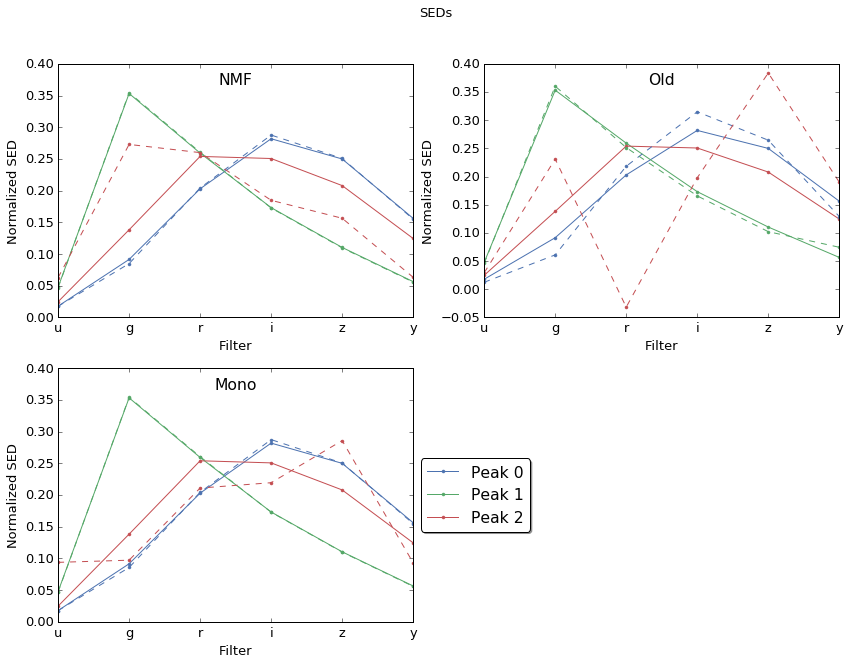

In [186]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
display.compareSeds([simTable, glmm.seds], filters, ax=ax1, show=False)
display.compareSeds([simTable, peakTable], filters, ax=ax2, show=False)
display.compareSeds([simTable, glmm2.seds], filters, ax=ax3, show=False)
fig.suptitle("SEDs")
ax1.set_title("NMF", y=.9)
ax2.set_title("Old", y=.9)
ax3.set_title("Mono", y=.9)
plt.legend(loc="center left", fancybox=True, shadow=True, ncol=1, bbox_to_anchor=(1, 0.5))
plt.show()

In [91]:
simFullTemplates = sim.getSimTemplates(simTable, filters, display=False)
templates = OrderedDict([
    ("old", oldTemplates),
    ("new", debTemplates),
    ("new mono", monoTemplates),
    ("new mono apportioned", monoApportioned),
    ("sim", simFullTemplates),
])
allSources = sim.makeAllMeasurements(templates, filters, expDb.calexps, footprint, thresh=1e-13)

In [197]:
import imp
imp.reload(sim)
imp.reload(debUtils)
imp.reload(display)

<module 'lsst.meas.deblender.display' from '/Users/fred/lsst/code/meas_deblender/python/lsst/meas/deblender/display.py'>

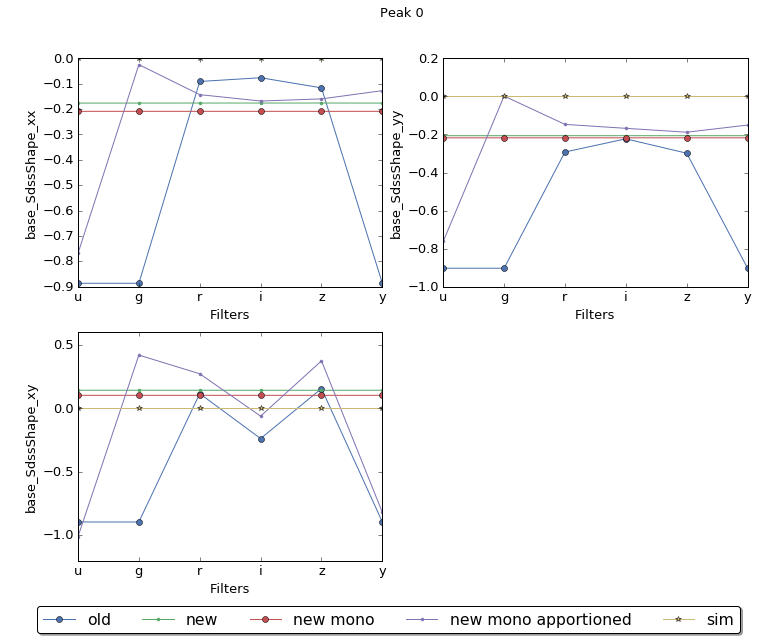

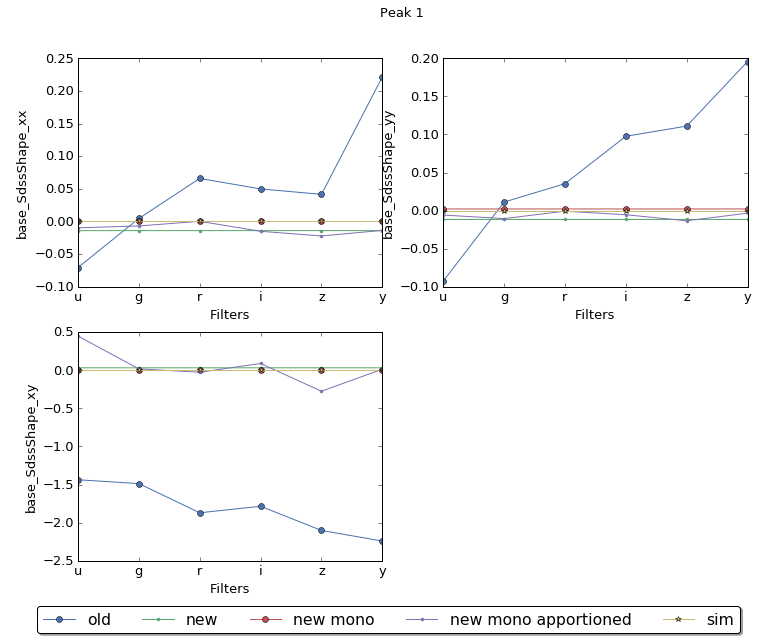

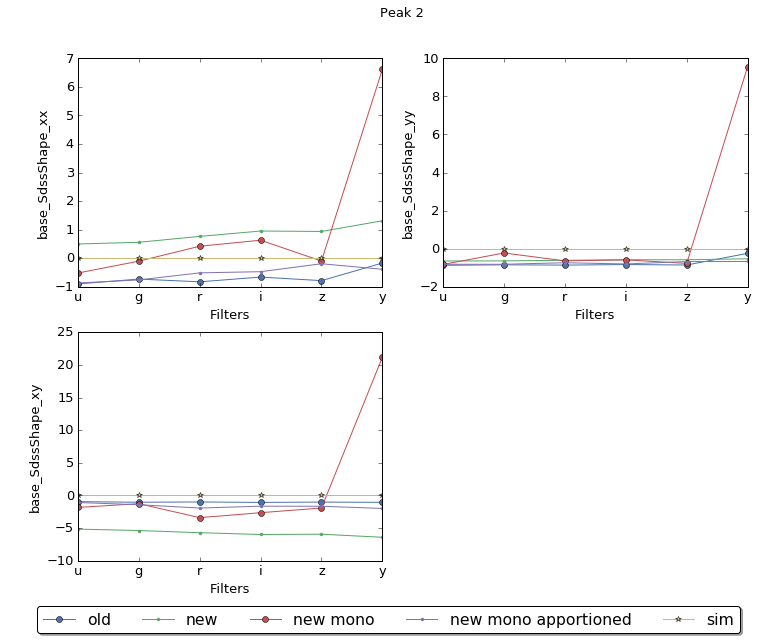

In [198]:
columns = [
    #"base_GaussianFlux_flux",
    "base_SdssShape_xx",
    "base_SdssShape_yy",
    "base_SdssShape_xy"
]

for pk, src in enumerate(allSources["sim"][filters[0]]):
    sim.compareSourceColumns(allSources, columns, pk, filters=filters)